In [2]:
# Description: This file contains the code for the VGG16 feature extractos model
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow import io
from tensorflow import data
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd 
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from keras import layers
from keras.utils import image_dataset_from_directory
import matplotlib.cm as cm
import cv2
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from keras.applications.vgg16 import VGG16, preprocess_input

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/MyDrive/CS5242

Mounted at /content/drive/
/content/drive/MyDrive/CS5242


## Feature Extractor
### Using VGG16 as feature extractor and save the extraced Data
Since the VGG16 has a deep architecture and has been trained on large-scale image datasets like ImageNet, which makes them excellent feature extractors for other classification tasks

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')

def process_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def save_feature_vector(input_folder, output_folder, model):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        img_path = os.path.join(input_folder, filename)
        img_array = process_image(img_path)
        features = model.predict(img_array)
        npy_file = os.path.splitext(filename)[0] + '.npy'
        np.save(os.path.join(output_folder, npy_file), features)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
input_folders = ['./cs52425242/frames/train/weap', './cs52425242/frames/train/norm']
output_folders = ['./train_array/weap_features', './train_array/norm_features']

for input_folder, output_folder in zip(input_folders, output_folders):
    save_feature_vector(input_folder, output_folder, base_model)

In [ ]:
input_folders = ['./cs52425242/frames/test/weap', './cs52425242/frames/test/norm']
output_folders = ['./test_array/weap_features', './test_array/norm_features']

for input_folder, output_folder in zip(input_folders, output_folders):
    save_feature_vector(input_folder, output_folder, base_model)

1/1 [==============================] - 0s 361ms/step


## Train our own model for the weapon task

### Load the extracted data

In [4]:
from sklearn.preprocessing import LabelEncoder

def load_features_labels(folder):
    X = []
    y = []

    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        feature_vector = np.load(file_path)
        X.append(feature_vector)
        y.append(os.path.basename(folder))

    return np.array(X), y

In [5]:
weap_features, weap_labels = load_features_labels('./train_array/weap_features')
norm_features, norm_labels = load_features_labels('./train_array/norm_features')

X = np.concatenate((weap_features, norm_features))
y = np.concatenate((weap_labels, norm_labels))

# Encode labels to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

### Base model
First, we use the simple model with only fully connected network and dropout layers to be the classifier

In [7]:
from keras.layers import Dropout,Flatten
# Create a simple fully connected neural network
model = Sequential([
    Flatten(input_shape=(1, 512)),
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_validation, y_validation))

Epoch 1/10
536/536 [==============================] - 6s 8ms/step - loss: 0.7626 - accuracy: 0.6923 - val_loss: 0.4190 - val_accuracy: 0.8289
Epoch 2/10
536/536 [==============================] - 5s 9ms/step - loss: 0.4231 - accuracy: 0.8051 - val_loss: 0.3202 - val_accuracy: 0.8872
Epoch 3/10
536/536 [==============================] - 4s 7ms/step - loss: 0.3260 - accuracy: 0.8565 - val_loss: 0.2331 - val_accuracy: 0.9085
Epoch 4/10
536/536 [==============================] - 4s 7ms/step - loss: 0.2540 - accuracy: 0.8898 - val_loss: 0.1771 - val_accuracy: 0.9349
Epoch 5/10
536/536 [==============================] - 4s 8ms/step - loss: 0.2151 - accuracy: 0.9135 - val_loss: 0.1551 - val_accuracy: 0.9421
Epoch 6/10
536/536 [==============================] - 4s 8ms/step - loss: 0.1877 - accuracy: 0.9233 - val_loss: 0.1402 - val_accuracy: 0.9517
Epoch 7/10
536/536 [==============================] - 4s 7ms/step - loss: 0.1623 - accuracy: 0.9384 - val_loss: 0.1222 - val_accuracy: 0.9535
Epoch 

#### Evaluate the basic model

In [8]:
test_weap_features, test_weap_labels = load_features_labels('./test_array/weap_features')
test_norm_features, test_norm_labels = load_features_labels('./test_array/norm_features')

X_test = np.concatenate((test_weap_features, test_norm_features))
y_test = np.concatenate((test_weap_labels, test_norm_labels))

# Encode labels to integers
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)

In [10]:
model.evaluate(X_test, y_test, batch_size=32)

127/127 [==============================] - 0s 3ms/step - loss: 1.0567 - accuracy: 0.6992


[1.0566647052764893, 0.6992351412773132]

##### Loss Graphs

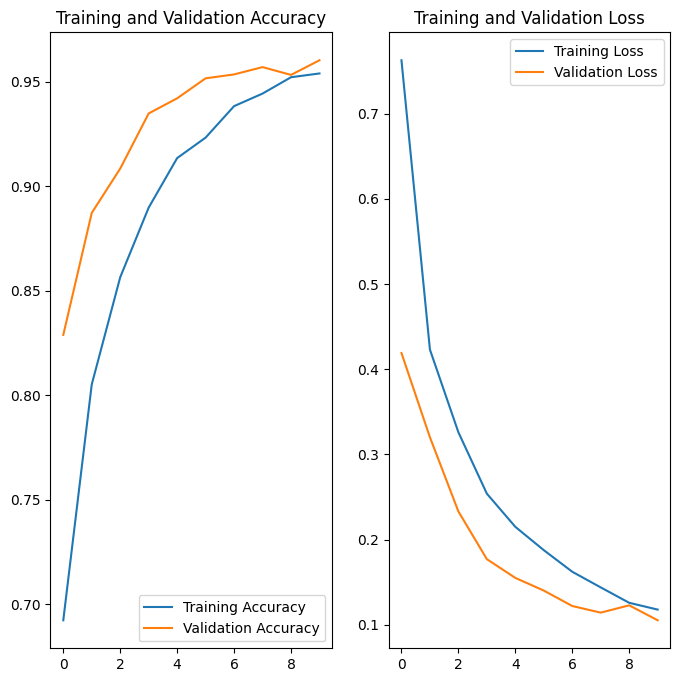

In [11]:
def plot_loss_acc_graphs(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
epochs = 10
plot_loss_acc_graphs(history)

##### Confusioin Matrices

In [12]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype('int32').flatten()

127/127 [==============================] - 0s 3ms/step


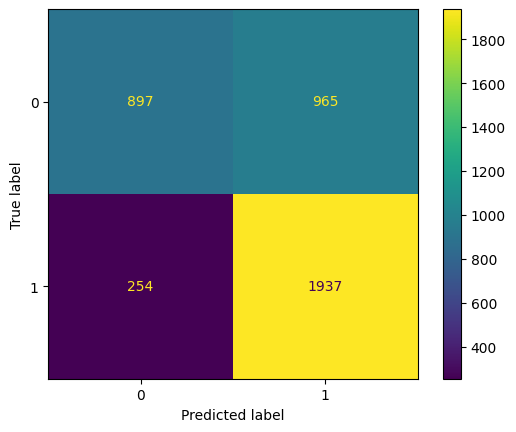

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
baseline_display = ConfusionMatrixDisplay(confusion_matrix=cm)
baseline_display.plot()
plt.show()

### Model with extra convolutional layer
Additionaly we add the Conv1D layers and BatchNormalization layer to define another deeper CNN( as much as out Conv2D layers in our own CNN) .because the extracted data is no longer images, so we can’t still directly use our own model to be classifier.  

#### Model defination

In [14]:
model_2 = Sequential([
  layers.Input(shape=(1,512)),

  layers.Conv1D(64, 1, activation='relu'),
  # layers.MaxPooling1D(1), #3x3 pooling
  layers.BatchNormalization(),

  layers.Conv1D(64, 1, activation='relu'),
  # layers.MaxPooling2D(3),
  layers.Dropout(0.2),
  layers.BatchNormalization(),

  layers.Conv1D(64, 1, activation='relu'),
  # layers.MaxPooling2D(3), #3x3 pooling
  layers.Dropout(0.2),
  layers.BatchNormalization(),

  layers.Conv1D(16, 1, activation='relu'),
  # layers.MaxPooling1D(2), #2x2 pooling
  layers.Dropout(0.2),
  layers.BatchNormalization(),

  
  layers.Flatten(),

  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),

  # layers.Dense(2)
  layers.Dense(1, activation='sigmoid')
])
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_2 = model_2.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_validation, y_validation))

Epoch 1/10
536/536 [==============================] - 10s 12ms/step - loss: 0.5298 - accuracy: 0.7206 - val_loss: 0.3768 - val_accuracy: 0.8319
Epoch 2/10
536/536 [==============================] - 4s 7ms/step - loss: 0.3558 - accuracy: 0.8469 - val_loss: 0.2839 - val_accuracy: 0.8870
Epoch 3/10
536/536 [==============================] - 3s 6ms/step - loss: 0.2769 - accuracy: 0.8866 - val_loss: 0.2273 - val_accuracy: 0.9166
Epoch 4/10
536/536 [==============================] - 4s 8ms/step - loss: 0.2290 - accuracy: 0.9107 - val_loss: 0.2093 - val_accuracy: 0.9176
Epoch 5/10
536/536 [==============================] - 4s 8ms/step - loss: 0.1956 - accuracy: 0.9245 - val_loss: 0.1870 - val_accuracy: 0.9293
Epoch 6/10
536/536 [==============================] - 3s 6ms/step - loss: 0.1711 - accuracy: 0.9330 - val_loss: 0.1630 - val_accuracy: 0.9386
Epoch 7/10
536/536 [==============================] - 3s 6ms/step - loss: 0.1486 - accuracy: 0.9442 - val_loss: 0.1605 - val_accuracy: 0.9388
Epoc

#### Evaluate the model

In [15]:
model_2.evaluate(X_test, y_test, batch_size=32)

127/127 [==============================] - 0s 3ms/step - loss: 0.8745 - accuracy: 0.6978


[0.8744683861732483, 0.6977547407150269]

##### Loss graphs

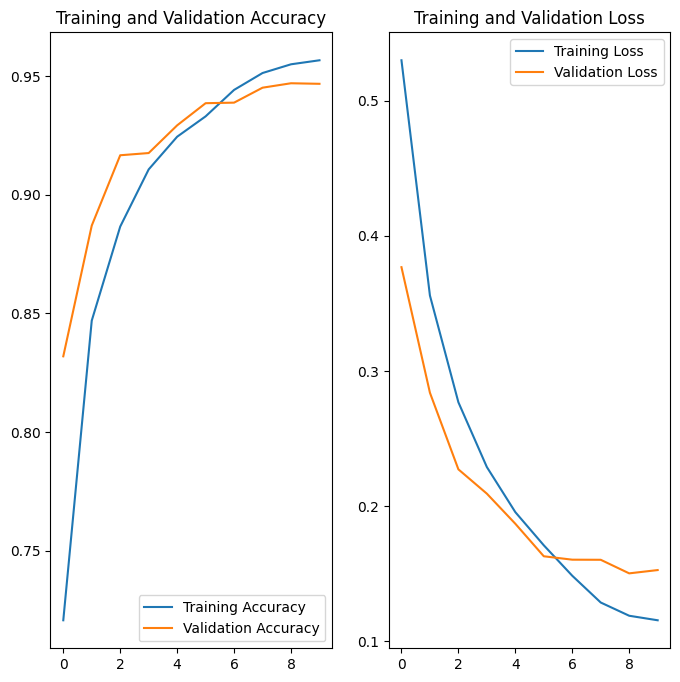

In [16]:
plot_loss_acc_graphs(history_2)

So as we can see, the more complex model have no better performance in accuracy, but it shows that model need less epoch to get well fitted

##### Confusion Matrices

127/127 [==============================] - 0s 2ms/step


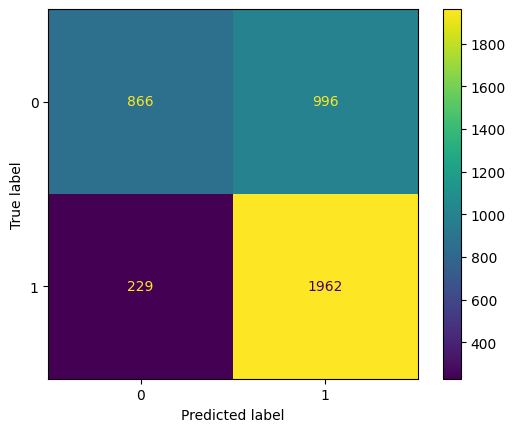

In [17]:
y_pred_probs_2 = model_2.predict(X_test)
y_pred_2 = (y_pred_probs_2 > 0.5).astype('int32').flatten()
cm_2 = confusion_matrix(y_test, y_pred_2)
extra_display = ConfusionMatrixDisplay(confusion_matrix=cm_2)
extra_display.plot()
plt.show()

The more complicate model shows same and even worse performance.so, we supposed that Use the extracted features from the training data to train our custom classifier. The classifier can be a simple one, a fully connected network, or even a traditional machine learning algorithm such as SVM or logistic regression.


## Visualize the extractor
In order to see how the VGG16 works as the feature extracor, we directly visualize the features that the final convocational layer extract and use the Grad-Cam to see which part contributed more.

### Feature visualization 

In [18]:
from keras.applications.vgg16 import preprocess_input

1/1 [==============================] - 0s 462ms/step


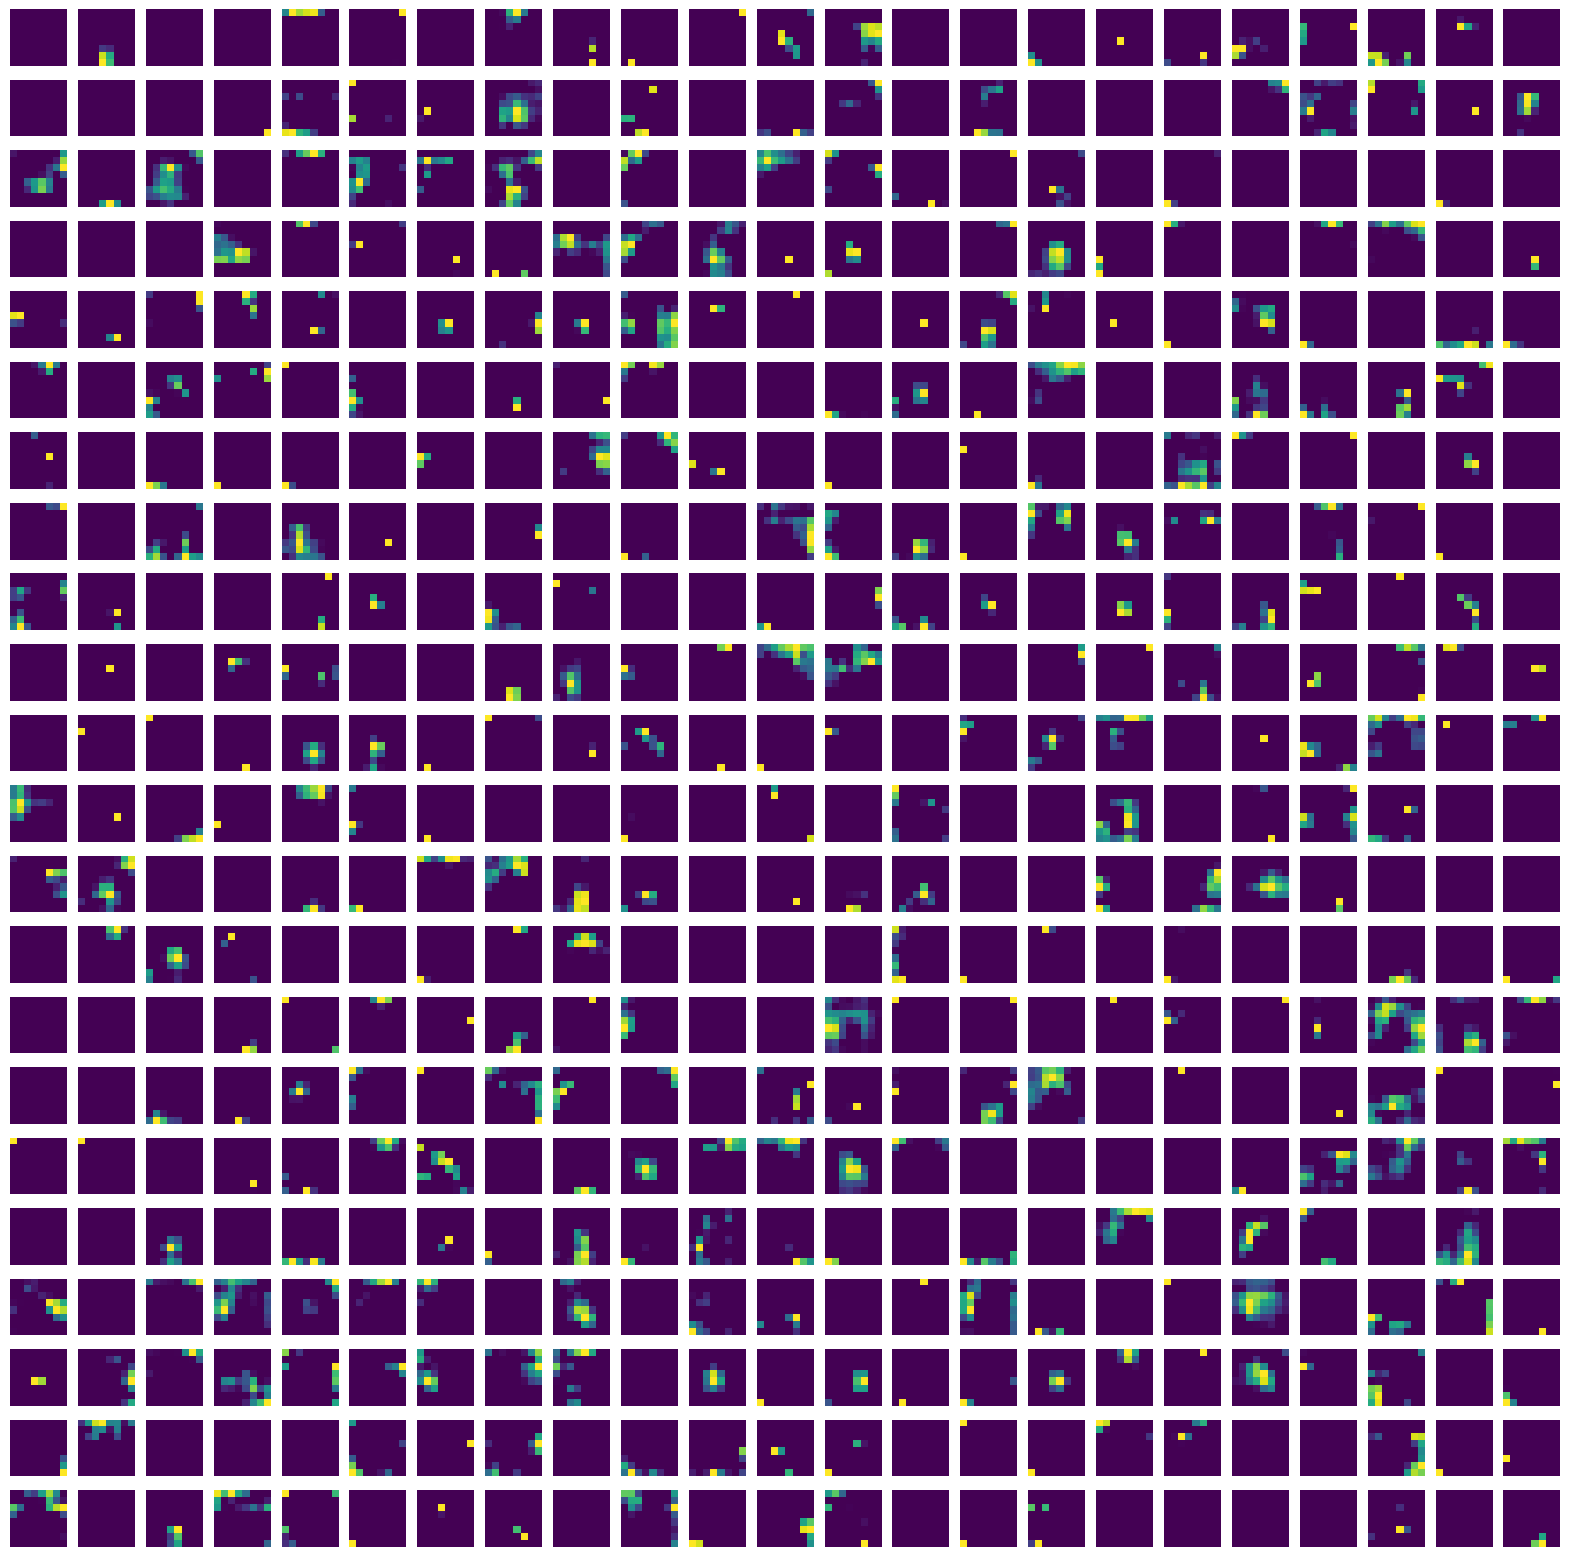

In [ ]:
# Load the image and preprocess it
img_path = './cs52425242/frames/train/weap/1(LEE KANG WEI)_140.png'
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Load the VGG16 model
base_model_vis = VGG16(weights='imagenet', include_top=False)

# Choose an intermediate layer for visualization
layer_name = 'block5_conv3'  
intermediate_layer_model = tf.keras.Model(inputs=base_model_vis.input, outputs=base_model_vis.get_layer(layer_name).output)

# Extract the features from the chosen layer
intermediate_output = intermediate_layer_model.predict(img_array)

# Visualize the features
n_features = intermediate_output.shape[-1]
rows = int(np.sqrt(n_features))
cols = n_features // rows

fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
for i in range(rows):
    for j in range(cols):
        ax = axes[i, j]
        ax.imshow(intermediate_output[0, :, :, i*cols + j], cmap='viridis')
        ax.axis('off')

plt.show()

### Grad-Cam

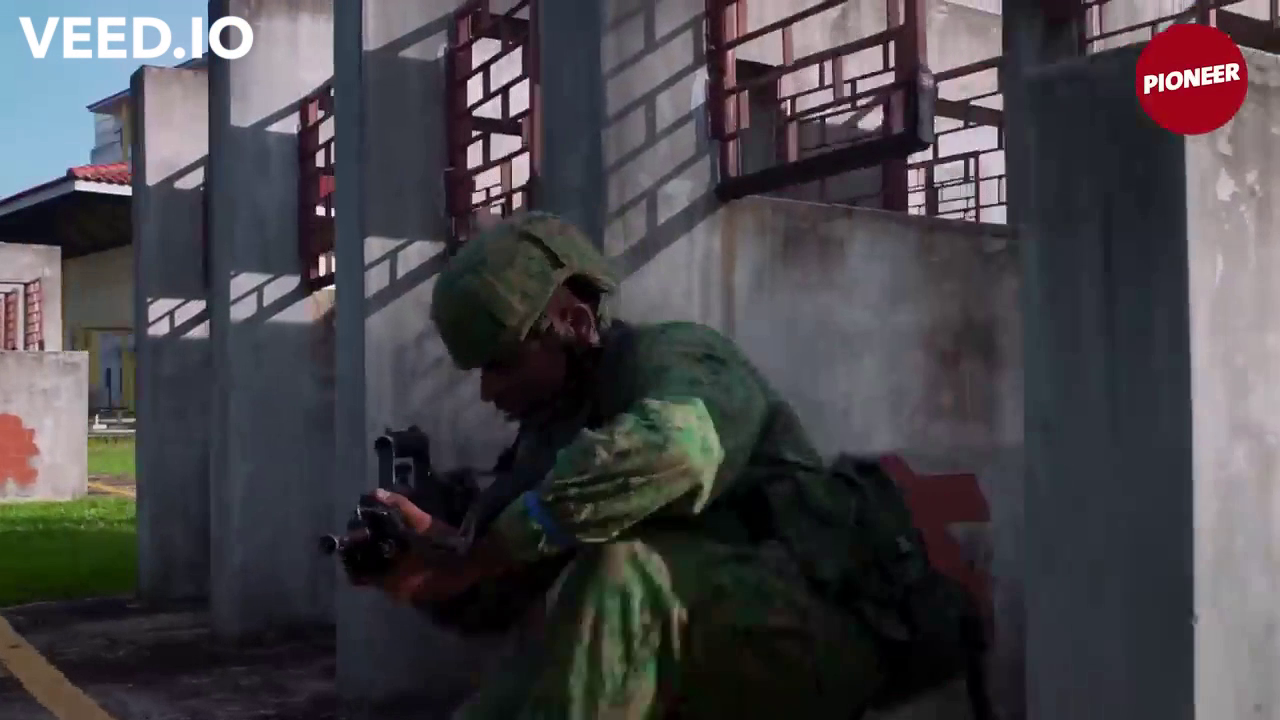

In [ ]:
import matplotlib.cm as cm
from IPython.display import Image, display
img_path = './cs52425242/frames/train/weap/1(LEE KANG WEI)_140.png'
img_size = (256, 256)

last_conv_layer_name = 'block5_conv3'

display(Image(img_path))

In [ ]:
img = keras.preprocessing.image.load_img(img_path, target_size=img_size, grayscale=True)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

/usr/local/lib/python3.9/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [ ]:
def gradcam(img_array, model, last_conv_layer_name):

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
      last_conv_layer_output, preds = grad_model(img_array)
      pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def show_grad(img_array, model, last_conv_layer_name, cam_path="./cam.jpg"):
    heatmap = gradcam(img_array, model, last_conv_layer_name)

    plt.matshow(heatmap)
    plt.show()

    # Overlaying grad cam over original image
    alpha = 0.4

    cam_img = keras.preprocessing.image.load_img(img_path)
    cam_img = keras.preprocessing.image.img_to_array(cam_img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet") #matplotlib.colormaps.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((cam_img.shape[1], cam_img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + cam_img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)


    # plt.imshow(superimposed_img)
    # plt.show()
    superimposed_img.save(cam_path)

    display(Image(cam_path))

    prediction = model.predict(img_array)
    print("Predicted class: ", prediction)
    

In [ ]:
def process_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array
img_array = process_image(img_path)

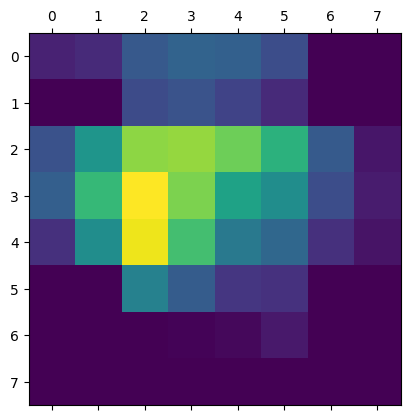

<ipython-input-11-3cce8eabe935>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet") #matplotlib.colormaps.get_cmap("jet")


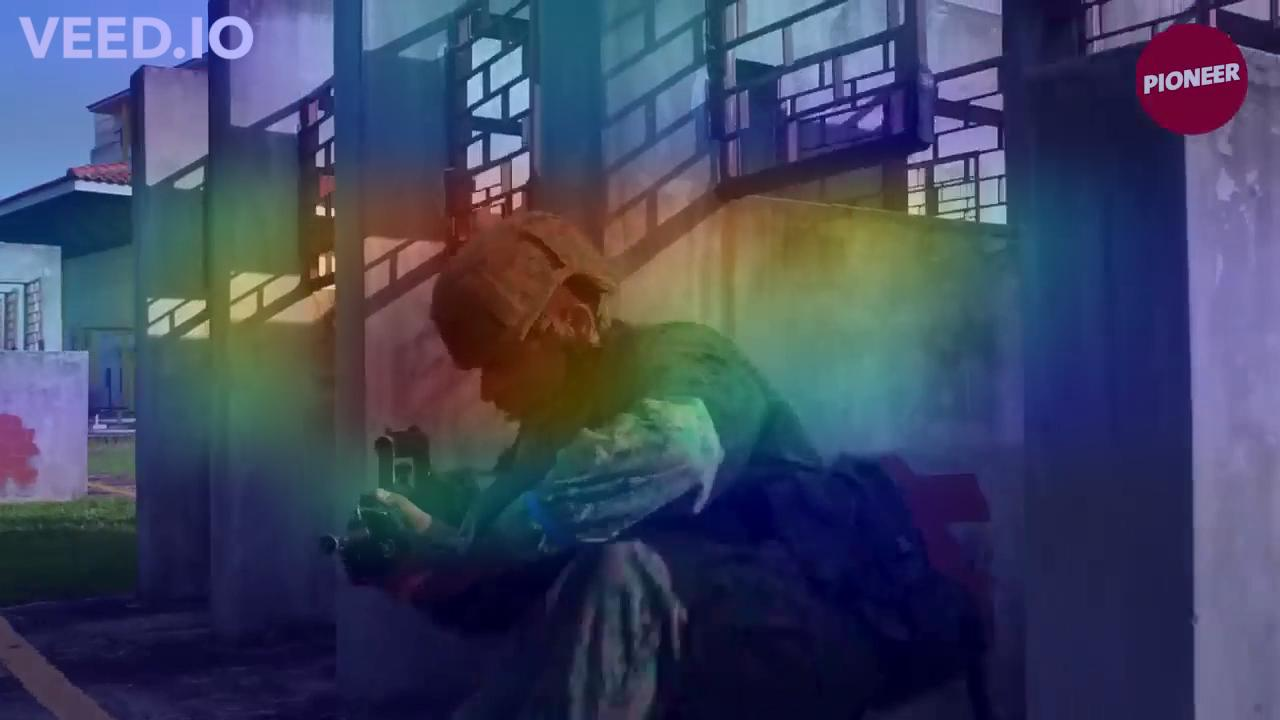

1/1 [==============================] - 0s 399ms/step
Predicted class:  [[0.00000000e+00 3.04278183e+00 0.00000000e+00 0.00000000e+00
  2.73230791e+00 8.69071782e-01 0.00000000e+00 5.07421589e+00
  2.89880514e-01 5.78885436e-01 6.11024141e-01 6.05890942e+00
  1.11300030e+01 0.00000000e+00 0.00000000e+00 1.81767678e+00
  8.78274143e-02 3.51299047e-01 4.30658102e+00 1.95918810e+00
  2.37115479e+00 3.26114178e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.03927863e+00 4.30027056e+00
  6.35572970e-01 1.63179517e-01 2.13568687e+01 0.00000000e+00
  1.26188862e+00 0.00000000e+00 1.35576737e+00 5.75144339e+00
  0.00000000e+00 5.22369576e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.44982147e+00 7.37312698e+00 1.54409730e+00
  1.82004660e-01 5.82010412e+00 8.50654030e+00 1.71560049e+00
  2.72462425e+01 0.00000000e+00 4.83594465e+00 1.09907160e+01
  3.59141946e+00 1.73585415e+01 0.00000000e+00 2.86965799e+00
  0.00000000e+00 1.55735044e+01 3.84471655e+00 4.75552499e-01

In [ ]:
show_grad(img_array, base_model, last_conv_layer_name)

As we can see in the Grad-Cam picture, the most contribute part is the man rather than the background, it is reasonable and i guess it can visulize why VGG is better.